## Feature Extraction, New and Improved

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from pathlib import Path
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
from scipy.fftpack import fft, dct

## Using audio data 

In [2]:
samples, sample_rate = librosa.load('../../../Source/Clean_train_clips/Shuffle/1/1.wav')

**Visualize audio files with librosa**

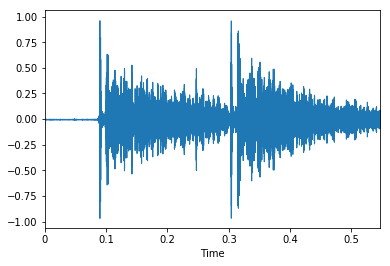

In [3]:
librosa.display.waveplot(samples, sr=sample_rate)

### Feature: 
BPM

Let's try it with a longer sample with a known BPM.

In [ ]:
# Estimate a static tempo
y, sr = librosa.load( '../../../workout.wav')
onset_env = librosa.onset.onset_strength(y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
tempo.item() #according to song BPM the correct tempo is 174 BPM

In [ ]:
# Maybe it's not a static tempo

# But rather a dynamic tempo
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr,
                            aggregate=None)
dtempo

Now with short, tap sample.

In [ ]:
# Estimate a static tempo
#y, sr = librosa.load('../../../Source/Clean_train_clips/Ball_change/6/1.wav')
y, sr = librosa.load('../../../Source/Shuffle/1/1.wav')
onset_env = librosa.onset.onset_strength(y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
tempo 

**This could be a promising feature.**

### Other (maybe useful) stuff from librosa

In [ ]:
y, sr = librosa.load('../../../Source/Shuffle/1/1.wav', mono=False)
y.shape # Check mono or stereo

In [ ]:
librosa.core.get_duration(y =y, sr=sr) # Get duration in seconds

## Trying out new features

**Short-time Fourier transform (STFT)**

In [ ]:
def get_features_stft (path):
        y, sr = librosa.load(path)
        return np.abs(librosa.stft(y))

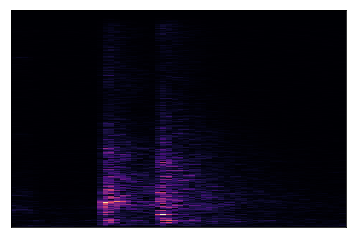

In [93]:
y, sr = librosa.load('../../../Source/Shuffle/1/1.wav')
D = np.abs(librosa.stft(y))
D.shape, D
librosa.display.specshow(D);

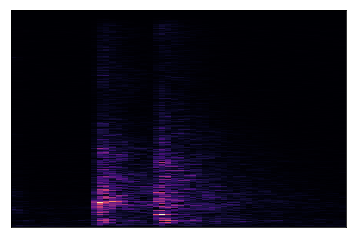

In [92]:
# Using left-aligned frames
D_left = np.abs(librosa.stft(y, center=False))
D_left.shape, D_left
librosa.display.specshow(D_left);

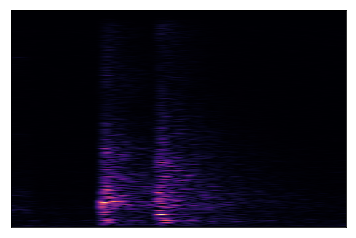

In [91]:
# Using a shorter hop length
D_short = np.abs(librosa.stft(y, hop_length=64))
D_short.shape, D_short
librosa.display.specshow(D_short);

**Fast Fourier Transform**

In [96]:
y, sr = librosa.load('../../../Source/Shuffle/1/1.wav')
fftrans = fft(y).real
fftrans.shape, fftrans
#librosa.display.specshow(fftrans);

((29400,), array([-0.48661616, -0.03262319, -0.06228644, ...,  0.0907427 ,
        -0.06228644, -0.03262319], dtype=float32))

In [ ]:
def get_features_fft(path):
    y, sr = librosa.load(path)
    return fft(y).real

**Discrete Cosine Transform**

In [82]:
y, sr = librosa.load('../../../Source/Shuffle/1/1.wav')
dctrans = dct(y) #dct(y, 1)
dctrans.shape, dctrans

((29400,), array([-9.73232388e-01, -1.36654168e-01, -6.52595758e-02, ...,
        -1.06346607e-03, -1.09087676e-04,  1.08236820e-03], dtype=float32))

In [ ]:
def get_features_dct(path):
    y, sr = librosa.load(path)
    return dct(y)

### Feature:
Mel-frequency cepstral coefficients 

In [54]:
n_mfcc = 20   #Remember to change file path at end of nb

In [55]:
# Extract mfcc feature from data
mfccs = np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=n_mfcc).T,axis=0) 

In [63]:
len(mfccs)
#librosa.display.specshow(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=n_mfcc))

20

### Repeat for all data (Organize in a DataFrame)

In [ ]:
def build_list(step, folder, length):
    i = 1
    step_list = []
    while i <= length :
        name = step + "/" + str(folder) + "/" +str(i) + ".wav"
        step_list.append(name)
        i += 1
    return step_list

def get_label(path):
    if path.parts[-3] == 'Shuffle':
        return 1
    else:
        return 0

In [ ]:
shuffle_col, bc_col, path_col = [], [], []

In [ ]:
pathlist = Path('../../../Source/Clean_train_clips/Shuffle').glob('**/*.wav')
for path in pathlist:
    shuffle_col.append(path)
    shuffle_col.sort()

In [ ]:
pathlist = Path('../../../Source/Clean_train_clips/Ball_change').glob('**/*.wav')
for path in pathlist:
    bc_col.append(path)
    bc_col.sort()

In [ ]:
path_col = shuffle_col + bc_col

** Add file paths**

In [ ]:
tap = pd.DataFrame({'Path':path_col})
tap

** Add labels**

In [ ]:
tap['Labels'] = [get_label(tap.loc[idx,'Path']) for idx in range(len(tap))]

**Add Features: MFCCs**

In [ ]:
def get_features_mfcc(path):
    samples, sample_rate = librosa.load(path)
    mfccs = np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=n_mfcc).T,axis=0)
    return mfccs

In [ ]:
for i in range (n_mfcc):
    tap[str(i)] = [get_features_mfcc(tap.loc[idx, 'Path'])[i] for idx in range (len(tap))]

In [ ]:
tap.head()

** Add Features: Tempo**

In [ ]:
def get_features_bpm(path):
    samples, sample_rate = librosa.load(path)
    onset_env = librosa.onset.onset_strength(samples, sr=sample_rate)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sample_rate)
    return tempo.item()

In [ ]:
tap['BPM'] = [get_features_bpm(tap.loc[idx, 'Path']) for idx in range (len(tap))]

In [ ]:
tap.head()

** Add features: zero-crossing rate**

In [ ]:
y, sr = librosa.load('../../../Source/Clean_train_clips/Shuffle/1/12.wav')
zero_rate = librosa.feature.zero_crossing_rate(y)
zero_rate.shape[1]

In [ ]:
samples, sample_rate = librosa.load('../../../Source/Clean_train_clips/Shuffle/1/10.wav')
avg_zcr = np.mean(librosa.feature.zero_crossing_rate(y=samples).T,axis=0)
zcrs= librosa.feature.zero_crossing_rate(samples)

print((librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=n_mfcc)).shape)
print(zcrs.shape)
print(np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=n_mfcc).T,axis=0).shape)
print(avg_zcr.shape)

In [ ]:
def get_features_ZCR(path):
    samples, sample_rate = librosa.load(path)
    return np.mean(librosa.feature.zero_crossing_rate(y=samples).T,axis=0).item()

In [ ]:
tap['ZCR'] = [get_features_ZCR(tap.loc[idx, 'Path']) for idx in range (len(tap))]

** Add features: root mean square energy value**

In [ ]:
def get_features_rmse(path):
    samples, sample_rate = librosa.load(path)
    return np.mean(librosa.feature.rmse(y=samples).T,axis=0).item()

In [ ]:
tap['RMSE'] = [get_features_rmse(tap.loc[idx, 'Path']) for idx in range (len(tap))]

** Add features: short term energy**

In [ ]:
def get_features_ste(path):
    hop_length = 125
    frame_length = 250
    samples, sample_rate = librosa.load(path)
    energy = np.array([sum(abs(samples[i:i+frame_length]**2))for i in range(0, len(samples), hop_length)])
    return np.mean(energy.T)

In [ ]:
tap['STE'] = [get_features_ste(tap.loc[idx, 'Path']) for idx in range (len(tap))]

### Pimped out DataFrame

In [ ]:
tap.head()

### Split into train and test sets

In [ ]:
X = tap.drop(['Labels'], axis =1)
y = tap[['Labels']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [ ]:
X_train.to_csv('../../../Source/Data/X_train_audio_f.csv', index=None)
y_train.to_csv('../../../Source/Data/y_train_audio_f.csv', index=None)
X_test.to_csv('../../../Source/Data/X_test_audio_f.csv', index=None)
y_test.to_csv('../../../Source/Data/y_test_audio_f.csv', index=None)


In [ ]:
tap.to_csv('../../../Source/Data/audio_data_f.csv', index=None)